# Installation Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [16]:
import numpy as np
import pandas as pd
import dask.dataframe as dd
from scipy import stats
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns; sns.set()
from pandas.tseries.offsets import *
from dateutil.relativedelta import *
import datetime as dt
import os
from IPython.core.pylabtools import figsize
from IPython.core.interactiveshell import InteractiveShell
%matplotlib inline 
#pylab.rcParams['figure.figsize'] = (20,10)
import os
os.chdir('./..')
print(f'Current working directory: {os.getcwd()}')

Current working directory: /Users/bill/Documents/GitHub


In [3]:
import pickle
from multiprocessing import Pool 
import random
import json
import sys
import StockPortfolioEnv

import pytz
import itertools
from datetime import datetime as dt
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl import config
from finrl import config_tickers
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)

if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

In [28]:
InteractiveShell.ast_node_interactivity = "all"
pd.options.display.float_format = '{:,.3f}'.format
pd.set_option('mode.use_inf_as_na', True)
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 500)
idx = pd.IndexSlice
import warnings
warnings.filterwarnings('ignore')
fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = INDICATORS,
                     use_turbulence=True,
                     user_defined_feature = False)

# Load Data

In [5]:
df_merged = pd.read_csv('data/merged.csv')
df_merged

,tic,permno,date,moribvol,russellgroup,sector,price,ret_1,ret_5,ret_10,ret_20,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,turbulence
0,ORCL,10104,2007-01-03,-0.168,1,XLK,17.510,0.010,0.015,-0.022,-0.026,17.220,17.780,17.100,14.514,52241700,2,0.000,14.783,14.385,100.000,66.667,100.000,14.514,14.514,0.000
1,ORCL,10104,2007-01-04,0.046,1,XLK,17.680,-0.002,-0.016,-0.023,-0.015,17.550,17.870,17.300,14.654,33559800,3,0.003,14.783,14.385,100.000,66.667,100.000,14.584,14.584,0.000
2,ORCL,10104,2007-01-05,-0.210,1,XLK,17.640,0.012,-0.008,-0.036,-0.027,17.620,17.760,17.440,14.621,36154800,4,0.003,14.744,14.449,80.425,49.450,100.000,14.596,14.596,0.000
3,ORCL,10104,2007-01-08,-0.142,1,XLK,17.860,-0.002,-0.031,-0.041,-0.047,17.630,17.930,17.450,14.804,31018100,0,0.009,14.888,14.409,90.740,122.246,100.000,14.648,14.648,0.000
4,ORCL,10104,2007-01-09,-0.102,1,XLK,17.820,-0.003,-0.017,-0.038,-0.051,17.930,17.980,17.650,14.770,31417000,1,0.011,14.907,14.438,82.556,107.926,100.000,14.673,14.673,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41542,FSLR,91611,2021-12-27,-0.259,2,XLK,87.860,-0.006,0.008,-0.041,-0.136,88.000,88.000,85.900,87.860,730700,0,-4.901,108.006,83.714,39.371,-128.157,32.102,99.672,103.856,0.041
41543,FSLR,91611,2021-12-28,0.013,2,XLK,87.350,-0.002,-0.001,-0.033,-0.126,88.250,88.700,87.080,87.350,560300,1,-4.892,106.433,83.337,39.019,-114.364,28.501,98.886,103.703,0.038
41544,FSLR,91611,2021-12-29,-0.104,2,XLK,87.180,0.010,-0.042,-0.035,-0.172,87.160,88.140,85.970,87.180,795300,2,-4.843,105.334,82.794,38.899,-112.652,31.659,98.049,103.572,0.004
41545,FSLR,91611,2021-12-30,0.049,2,XLK,88.040,-0.010,-0.046,-0.060,-0.166,87.760,89.290,87.400,88.040,837400,3,-4.680,104.367,82.401,39.866,-93.985,25.520,97.500,103.446,0.119


# Weight Initialization
## Retail Weights (Rank-based method)

In [6]:
# Compute a set of weights for asset allocation
df_merged['moribvol'] = df_merged.groupby(['date'])['moribvol'].rank(method='dense')
df_merged['moribvol'] = df_merged.groupby('date')['moribvol'].apply(lambda x: x/x.sum())

df_merged 

,tic,permno,date,moribvol,russellgroup,sector,price,ret_1,ret_5,ret_10,ret_20,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,turbulence
0,ORCL,10104,2007-01-03,0.045,1,XLK,17.510,0.010,0.015,-0.022,-0.026,17.220,17.780,17.100,14.514,52241700,2,0.000,14.783,14.385,100.000,66.667,100.000,14.514,14.514,0.000
1,ORCL,10104,2007-01-04,0.091,1,XLK,17.680,-0.002,-0.016,-0.023,-0.015,17.550,17.870,17.300,14.654,33559800,3,0.003,14.783,14.385,100.000,66.667,100.000,14.584,14.584,0.000
2,ORCL,10104,2007-01-05,0.015,1,XLK,17.640,0.012,-0.008,-0.036,-0.027,17.620,17.760,17.440,14.621,36154800,4,0.003,14.744,14.449,80.425,49.450,100.000,14.596,14.596,0.000
3,ORCL,10104,2007-01-08,0.076,1,XLK,17.860,-0.002,-0.031,-0.041,-0.047,17.630,17.930,17.450,14.804,31018100,0,0.009,14.888,14.409,90.740,122.246,100.000,14.648,14.648,0.000
4,ORCL,10104,2007-01-09,0.045,1,XLK,17.820,-0.003,-0.017,-0.038,-0.051,17.930,17.980,17.650,14.770,31417000,1,0.011,14.907,14.438,82.556,107.926,100.000,14.673,14.673,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41542,FSLR,91611,2021-12-27,0.015,2,XLK,87.860,-0.006,0.008,-0.041,-0.136,88.000,88.000,85.900,87.860,730700,0,-4.901,108.006,83.714,39.371,-128.157,32.102,99.672,103.856,0.041
41543,FSLR,91611,2021-12-28,0.076,2,XLK,87.350,-0.002,-0.001,-0.033,-0.126,88.250,88.700,87.080,87.350,560300,1,-4.892,106.433,83.337,39.019,-114.364,28.501,98.886,103.703,0.038
41544,FSLR,91611,2021-12-29,0.015,2,XLK,87.180,0.010,-0.042,-0.035,-0.172,87.160,88.140,85.970,87.180,795300,2,-4.843,105.334,82.794,38.899,-112.652,31.659,98.049,103.572,0.004
41545,FSLR,91611,2021-12-30,0.152,2,XLK,88.040,-0.010,-0.046,-0.060,-0.166,87.760,89.290,87.400,88.040,837400,3,-4.680,104.367,82.401,39.866,-93.985,25.520,97.500,103.446,0.119


## Mean-Variance Optimization Weights

In [7]:
#TODO: Compute and append mean variance weights to "df_merged" here, say column name as "mean-var"


## Data Split

In [8]:
states = ['date', 'open', 'high', 'low', 'close', 'volume', 'tic', 'day', 'macd', 'boll_ub', 'boll_lb', 'rsi_30', 'cci_30', 'dx_30', 'close_30_sma', 'close_60_sma', 'moribvol']

train_data = data_split(df_merged[states], '2007-01-01', '2018-01-01')
trade_data = data_split(df_merged[states], '2018-01-01', '2022-01-01')

# boom bust?

In [9]:
train_data

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,moribvol
0,2007-01-03,40.630,41.830,39.810,40.560,3873900,ADSK,2,0.000,42.034,39.856,100.000,66.667,100.000,40.560,40.560,0.136
0,2007-01-03,20.080,20.400,19.350,19.520,28350300,AMD,2,0.000,20.037,19.273,100.000,-66.667,100.000,19.520,19.520,0.061
0,2007-01-03,27.460,27.980,27.330,19.536,64226000,CSCO,2,0.000,20.520,19.066,100.000,66.667,100.000,19.536,19.536,0.015
0,2007-01-03,30.170,30.290,28.200,28.500,487000,FSLR,2,0.000,28.979,28.271,100.000,-66.667,100.000,28.500,28.500,0.152
0,2007-01-03,30.680,31.060,29.100,26.496,4734600,INTU,2,0.000,27.201,26.159,100.000,-66.667,100.000,26.496,26.496,0.121
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2768,2017-12-29,85.630,86.050,85.500,80.353,18717400,MSFT,4,0.755,82.580,76.658,60.144,74.372,15.450,79.209,77.226,0.136
2768,2017-12-29,47.530,47.880,47.280,43.361,9750000,ORCL,4,-0.469,46.547,42.377,42.781,-104.196,16.192,44.585,44.987,0.015
2768,2017-12-29,64.360,64.650,64.000,55.318,6631800,QCOM,4,0.254,56.595,55.253,56.700,-86.758,5.702,56.536,52.515,0.045
2768,2017-12-29,104.580,105.080,104.420,90.749,2813300,TXN,4,1.784,93.422,81.992,68.523,122.502,47.232,86.948,84.777,0.121


In [10]:
trade_data

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,moribvol
0,2018-01-02,105.340,107.160,104.390,107.120,2040600,ADSK,1,-3.126,109.299,103.069,42.401,-46.823,16.989,111.624,116.601,0.121
0,2018-01-02,10.420,11.020,10.340,10.980,44146300,AMD,1,-0.118,11.174,9.591,47.857,16.873,1.262,10.656,11.574,0.076
0,2018-01-02,38.670,38.950,38.430,33.136,20135700,CSCO,1,0.546,33.333,31.723,68.414,104.513,41.566,32.173,30.622,0.030
0,2018-01-02,67.840,70.500,67.840,70.430,1752200,FSLR,1,2.129,74.356,61.051,63.063,70.593,22.722,65.429,59.588,0.061
0,2018-01-02,158.220,158.850,157.010,152.836,1436100,INTU,1,1.228,155.434,147.894,59.470,59.491,11.443,150.864,147.513,0.152
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1007,2021-12-31,338.510,339.360,335.850,332.365,18000800,MSFT,4,2.333,343.209,315.177,55.069,41.028,10.666,330.022,322.471,0.152
1007,2021-12-31,88.050,88.100,87.180,85.402,5908200,ORCL,4,-1.536,102.358,79.414,43.416,-97.508,15.966,90.801,92.164,0.030
1007,2021-12-31,183.310,185.150,182.600,177.918,4113300,QCOM,4,3.541,184.097,169.783,59.872,46.197,34.435,176.387,157.506,0.076
1007,2021-12-31,189.410,190.000,188.270,181.990,2813900,TXN,4,-0.804,192.027,176.924,47.910,-71.323,5.853,185.032,185.000,0.136


In [11]:
# Last, save both train and trade dfs to csv in data foler
# TODO: add more features in "state" if needed
train_data.to_csv('data/train_data.csv', index=True)  
trade_data.to_csv('data/trade_data.csv', index=True) 

# Benchmarks
We compare the performance of different weighting methods on the train period
 - Mean Variance
 - Equally weighted (Buy and hold)
 - Market indexes (NASDAQ and XLK)
 - Individual stocks

## Environment configuration
> A gym-style portfolio allocation environment for agents to interact. It is handy to compare the performances.

In [12]:
train = train_data
trade = trade_data

stock_dimension = len(train.tic.unique())
state_space = stock_dimension
tech_indicator_list = ['macd', 'rsi_30', 'cci_30', 'dx_30']
feature_dimension = len(tech_indicator_list)

print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")
print(f"Feature Dimension: {feature_dimension}")

env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "transaction_cost_pct": 0, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": tech_indicator_list, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-1
}

e_train_gym = StockPortfolioEnv.StockPortfolioEnv(df = train, **env_kwargs)
e_trade_gym = StockPortfolioEnv.StockPortfolioEnv(df = trade, **env_kwargs)

Stock Dimension: 11, State Space: 11
Feature Dimension: 4


## Sampling

In [13]:
retail_train = StockPortfolioEnv.sample_from_env(i=0, env=e_train_gym, weights=train['moribvol'])

begin_total_asset:1000000
end_total_asset:4904419.075973194
Sharpe:  0.6729768484476762


In [20]:
# TODO: to be changed to excecute like the above function

# Mean variance
mean_var_df = pd.read_csv(os.getcwd()+'/FinRL_Imitation_Learning/data/mean_var_weight.csv')
mean_var_df = pd.concat([mean_var_df.iloc[[0]], mean_var_df], ignore_index=True)
mean_var_df = pd.concat([mean_var_df, mean_var_df.iloc[[len(mean_var_df)-1]]], ignore_index=True)
mean_var_df.loc[0, 'date'] = '2007-01-03'
mean_var_df.loc[len(mean_var_df)-1, 'date'] = '2017-12-29'
mean_var_df = mean_var_df.drop(mean_var_df.columns[0], axis=1)

mean_var_dataset = StockPortfolioEnv.sample_from_env(i=0, env=e_train_gym, weights=mean_var_df.values)
mean_var_cum_ret = pd.DataFrame({'ret': 1000000 + np.insert(mean_var_dataset['rewards'].cumsum(), 0, 0, axis=0)})
mean_var_cum_ret['ret'] /= 1000000

begin_total_asset:1000000
end_total_asset:2954456.9590735934
Sharpe:  0.58838920208855


In [29]:
# XLK
start = '2007-01-03'
end = '2016-12-06'
yf_xlk = YahooDownloader(start_date = start,
                         end_date = end,
                         ticker_list = ["XLK"]).fetch_data()

yf_xlk = fe.preprocess_data(yf_xlk)
yf_xlk = yf_xlk.copy()
yf_xlk = yf_xlk.fillna(0)
yf_xlk = yf_xlk.replace(np.inf,0)
# yf_xlk['date'] = pd.to_datetime(yf_xlk['date'])
yf_xlk = data_split(yf_xlk, '2007-01-01', '2018-01-01')  
yf_xlk['ret'] = yf_xlk['open'] / yf_xlk['open'].iloc[0]

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (2500, 8)
Successfully added technical indicators
Successfully added turbulence index


In [30]:
# individual
grouped = df_merged.groupby('tic')
selected_cum_ret = grouped.apply(lambda x: x['open']/x['open'].iloc[0])
selected_cum_ret = selected_cum_ret.reset_index()
selected_cum_ret = selected_cum_ret.set_index('level_1')
selected_cum_ret = selected_cum_ret.join(df_merged[['date']])
selected_cum_ret = data_split(selected_cum_ret, '2007-01-01', '2018-01-01')

## Performance Comparison

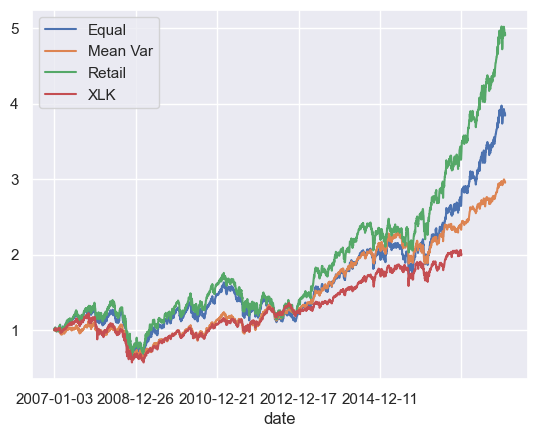

In [31]:
fig, ax = plt.subplots()

# Equal
equal_cum_ret = pd.read_csv(os.getcwd()+"/FinRL_Imitation_Learning/results/equal_cumulative_reward.csv", names=['ret'])
equal_cum_ret['date'] = selected_cum_ret['date'].unique()
ax = equal_cum_ret.plot(ax=ax, kind='line', x='date', y='ret', label="Equal")

# Mean Variance
mean_var_cum_ret['date'] = selected_cum_ret['date'].unique()
ax = mean_var_cum_ret.plot(ax=ax, kind='line', x='date', y='ret', label="Mean Var")

# Retail
retail_cum_ret = pd.read_csv(os.getcwd()+"/FinRL_Imitation_Learning/results/retail_cumulative_reward.csv", names=['ret'])
retail_cum_ret['date'] = selected_cum_ret['date'].unique()
ax = retail_cum_ret.plot(ax=ax, kind='line', x='date', y='ret', label="Retail")

# XLK
ax = yf_xlk.plot(ax=ax, kind='line', x='date', y='ret', label="XLK")

plt.show()

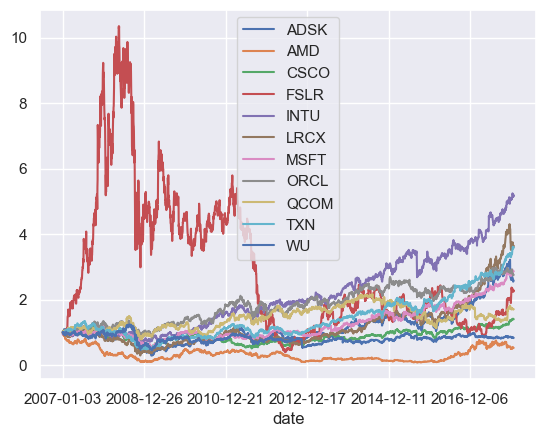

In [32]:
fig, ax = plt.subplots()

# 个股
for key, grp in selected_cum_ret.groupby(['tic']):
    ax = grp.plot(ax=ax, kind='line', x='date', y='open', label=key)
    
plt.show()